# Comprehensive Benchmarking of Parallel QAOA Portfolio Optimization with DWE

This notebook is dedicated to systematically benchmarking the performance and solution quality of our parallel QAOA implementation for portfolio optimization, leveraging the Domain Wall Encoding (DWE) technique. As a telecom engineer with a mission to raise quantum technology awareness, this empirical data will be invaluable.

We will evaluate how varying problem size, QAOA depth, optimizer effort, and the number of parallel processes impact both the time to solution and the quality of the results.

**Key enhancements in this benchmarking notebook:**
1.  **Systematic Parameter Variation:** We'll iterate through predefined ranges of `N`, `p`, `max_evals`, and `num_parallel_runs`.
2.  **Robust Data Collection:** Results from each run (including repetitions for statistical robustness) will be collected into a Pandas DataFrame.
3.  **Comprehensive Metrics:** We'll track wall-clock time, solution energy, approximation ratio (where applicable), and the critical constraint satisfaction rate.
4.  **Automated Visualization:** Plots will be generated to illustrate the trends and insights from the benchmarking data.

**Important Note on Multiprocessing and External Files:**
As we've discussed, the core functions for optimization (`minimize_nlopt`) and single QAOA runs (`run_single_optimization`) are now located in `qaoa_utils.py`. This best practice resolves common `AttributeError` issues in Jupyter when using `multiprocessing`, ensuring child processes can correctly access the necessary code.

## 1. Setup and Imports

We begin by importing all required libraries. This includes standard scientific computing libraries (`numpy`, `pandas`), multiprocessing utilities (`os`, `multiprocessing`, `concurrent.futures`, `functools`), and the quantum computing specific tools (`qiskit_aer`, `qokit`).

Crucially, `minimize_nlopt` and `run_single_optimization` are imported from `qaoa_utils.py`, which must be in the same directory as this notebook.

In [1]:
import numpy as np
import os 
import time 
import nlopt 
import multiprocessing 
from concurrent.futures import ProcessPoolExecutor 
from functools import partial 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import the core functions from the external file
from qaoa_utils import minimize_nlopt, run_single_optimization

from qiskit_aer import AerSimulator
from qokit.portfolio_optimization import get_sk_ini, portfolio_brute_force
from qokit.qaoa_objective_portfolio import get_qaoa_portfolio_objective

# Optional: for later analysis of optimal bitstring
from qiskit.circuit import ParameterVector
from qiskit.primitives import Sampler
from qokit.qaoa_circuit_portfolio import get_parameterized_qaoa_circuit

## 2. Problem Definition Function (with DWE)

To enable systematic benchmarking across various problem sizes (`N`), we've encapsulated the DWE-transformed QUBO problem definition into a function. This function will generate unique problem instances (based on a `problem_seed`) for each `N` being tested, ensuring consistency and reproducibility across runs for the same `N`.

For smaller `N` (e.g., up to 20), this function will also attempt to calculate the **classical brute-force optimal energy**. This allows us to compute the **Approximation Ratio (AR)**, a key metric for solution quality. For `N` larger than the brute-force feasibility limit, AR will not be calculated.

In [2]:
def define_po_problem(N, K, q, lambda_sum, problem_seed=None):
    """
    Defines the Portfolio Optimization problem with Domain Wall Encoding.
    Generates random mu and Sigma for the given N.
    Calculates classical brute-force solution for small N.
    """
    if problem_seed is not None:
        np.random.seed(problem_seed) # for reproducibility of problem instance definition

    mu = np.random.uniform(0.05, 0.20, N)
    Sigma = np.random.uniform(0.001, 0.015, (N, N))
    Sigma = (Sigma + Sigma.T) / 2 
    Sigma = Sigma + np.eye(N) * 0.005 # Ensure positive semi-definite

    # --- DWE Transformation Coefficients ---
    factor_J_obj = (2 * q) / (K**2) 
    factor_h_linear_obj = -1 / K
    factor_h_diagonal_obj = q / (K**2) 

    J_coeffs_objective = {}
    h_coeffs_objective = {}

    for i in range(N):
        for j in range(i + 1, N):
            J_coeffs_objective[(i, j)] = factor_J_obj * Sigma[i, j]

    for i in range(N):
        h_coeffs_objective[i] = factor_h_linear_obj * mu[i] + factor_h_diagonal_obj * Sigma[i, i]

    J_coeffs_total = {}
    h_coeffs_total = {}

    for (i, j), val in J_coeffs_objective.items():
        J_coeffs_total[(i, j)] = val + 2 * lambda_sum

    for i, val in h_coeffs_objective.items():
        h_coeffs_total[i] = val - 5 * lambda_sum

    po_problem = {
        "N": N,
        "K": K,
        "q": q, 
        "J": J_coeffs_total, 
        "h": h_coeffs_total, 
        "means": mu,         
        "cov": Sigma,        
        "q_orig": q,         
        "scale": 1.0         
    }

    best_portfolio = (None, None) 
    if N <= 20: # Threshold for classical brute-force feasibility
        try:
            # Brute-force solver expects the original problem definition without DWE penalty
            original_po_problem_for_brute_force = {"N":N, "K":K, "q":q, "means":mu, "cov":Sigma}
            best_portfolio = portfolio_brute_force(original_po_problem_for_brute_force, return_bitstring=False)
            # print(f"  Brute-force classical optimal energy for N={N}: {best_portfolio[0]:.6f}")
        except Exception as e:
            print(f"  Brute-force calculation failed for N={N}: {e}. Approximation Ratio will be 'N/A'.")
    
    return po_problem, best_portfolio

# Define global constant problem parameters that won't be varied in loops for this benchmark
GLOBAL_Q = 0.5 # Risk aversion parameter
GLOBAL_LAMBDA_SUM = 100 # DWE-inspired penalty coefficient for sum constraint

## 3. Helper Functions (`minimize_nlopt` & `run_single_optimization`)

As discussed, these essential functions are crucial for the parallel execution and are now imported from `qaoa_utils.py`.

* **`minimize_nlopt(f, x0, rhobeg=None, p=None, max_evals=None)`**: This function handles the classical optimization of QAOA parameters using NLopt's BOBYQA algorithm. It takes the QAOA objective function and an initial parameter guess. `max_evals` is used to limit the optimization effort.
* **`run_single_optimization(run_config, po_problem_arg, best_portfolio_arg)`**: This function orchestrates a single QAOA optimization run. It initializes a dedicated `AerSimulator`, sets up the QAOA objective for the given problem, calls `minimize_nlopt`, and computes the final energy and approximation ratio. It's designed to be executed by each parallel process.

In [3]:
# The functions minimize_nlopt and run_single_optimization are imported from qaoa_utils.py.
# Their definitions are NOT included here to prevent multiprocessing issues.
print("Ensure qaoa_utils.py is in the same directory and contains `minimize_nlopt` and `run_single_optimization` functions.")

Ensure qaoa_utils.py is in the same directory and contains `minimize_nlopt` and `run_single_optimization` functions.


## 4. Benchmarking Implementation

This is the core of the benchmarking. We'll set up nested loops to iterate through various combinations of problem sizes (`N`), QAOA depths (`p`), `max_evals` for the classical optimizer, and the number of parallel processes. For each unique combination, we'll run the experiment multiple times (`num_repetitions_per_setting`) to gather statistically robust data.

The `multiprocessing.ProcessPoolExecutor` will distribute the individual `run_single_optimization` calls across available CPU cores. `functools.partial` is used to efficiently pass the constant problem definition arguments to the parallel function.

In [10]:
all_benchmark_results = [] # List to store results from all experiments

# --- Benchmarking Parameters ---
# IMPORTANT: Adjust these ranges based on your system's capabilities and desired depth of analysis.
# Larger values will significantly increase execution time.
N_values = [21,22,23] # Number of assets to test
K_ratio = 0.4 # K = int(N * K_ratio). Ratio of assets to select.
p_values = [4,8,12] # QAOA depth (number of layers)
max_evals_values = [1] # Max function evaluations for NLopt per QAOA run
num_parallel_runs_values = [1, 2,4] # Number of parallel processes to use.
                                                 # `1` serves as a baseline for speedup calculation.
                                                 # `os.cpu_count()` uses all available logical cores.
num_repetitions_per_setting = 1
# How many times to repeat each (N, p, max_evals, num_procs) combination.
                                # Essential for statistical robustness due to random initializations.

# --- Seeds for Reproducibility ---
# These offsets ensure unique seeds for problem generation and parallel runs
PROBLEM_SEED_OFFSET = 1000 
RUN_SEED_OFFSET = 2000 

print("Starting comprehensive benchmarking experiments...")
print(f"Total configurations to test: {len(N_values) * len(p_values) * len(max_evals_values) * len(num_parallel_runs_values) * num_repetitions_per_setting}")
print("This may take a significant amount of time based on chosen parameters.")

if __name__ == "__main__":
    try:
        multiprocessing.set_start_method('spawn', force=True)
        print("Multiprocessing start method set to 'spawn'.")
    except RuntimeError:
        print("Multiprocessing start method already set (can happen in interactive environments).")

    for N in N_values:
        K = int(N * K_ratio)
        print(f"\n----- Running for N={N} (K={K}) -----")
        
        for p_val in p_values:
            print(f"  --- QAOA Depth (p)={p_val} ---")

            for max_evals_per_run in max_evals_values:
                print(f"    --- Max Evaluations per Run={max_evals_per_run} ---")

                for num_procs in num_parallel_runs_values:
                    print(f"      --- Parallel Processes={num_procs} ---")
                    
                    for rep_idx in range(num_repetitions_per_setting):
                        print(f"        Repetition {rep_idx + 1}/{num_repetitions_per_setting}...")
                        
                        # Regenerate the problem instance for EACH repetition to ensure different mu/Sigma.
                        # This makes the results more general across various problem instances.
                        # Adjust the seed generation if you want the exact same problem for all repetitions.
                        current_problem_seed = PROBLEM_SEED_OFFSET + N + p_val + max_evals_per_run + num_procs + rep_idx
                        po_problem, best_portfolio = define_po_problem(N, K, GLOBAL_Q, GLOBAL_LAMBDA_SUM, problem_seed=current_problem_seed)
                        
                        # Generate unique seeds for each parallel run within this repetition
                        current_parallel_run_configs = [
                            {'seed': RUN_SEED_OFFSET + (rep_idx * num_procs) + i, 'p': p_val, 'max_evals': max_evals_per_run}
                            for i in range(num_procs) 
                        ]

                        start_time = time.perf_counter()
                        
                        local_successful_results = []
                        with ProcessPoolExecutor(max_workers=num_procs) as executor:
                            # Use functools.partial to fix po_problem and best_portfolio for parallel execution
                            func_to_map = partial(run_single_optimization, 
                                                  po_problem_arg=po_problem, 
                                                  best_portfolio_arg=best_portfolio)
                            results_iterator = executor.map(func_to_map, current_parallel_run_configs)

                            for result in results_iterator:
                                if result is not None: 
                                    local_successful_results.append(result)
                                
                        end_time = time.perf_counter()
                        total_wall_time = end_time - start_time

                        # Process and store results for this specific repetition
                        if local_successful_results:
                            # Sort results to find the best from this set of parallel runs
                            local_successful_results.sort(key=lambda x: x['energy'])
                            best_run_overall = local_successful_results[0]
                            
                            # Re-run a quick simulation to get the actual most probable bitstring
                            # and check its constraint satisfaction. This happens on the main process.
                            sampler_backend = AerSimulator(method='statevector')
                            sampler_backend.set_options(max_parallel_threads=1, statevector_parallel_threshold=N+1)
                            
                            gamma_opt_params = best_run_overall['optimized_params'][:p_val]
                            beta_opt_params = best_run_overall['optimized_params'][p_val:]
                            
                            qaoa_circuit_for_bitstring = get_parameterized_qaoa_circuit(
                                po_problem=po_problem,
                                depth=p_val,
                                ini_type='dicke',
                                mixer_type='trotter_ring',
                                T=1,
                                simulator=sampler_backend, # Use the AerSimulator directly
                                mixer_topology='linear',
                                gamma=gamma_opt_params, 
                                beta=beta_opt_params
                            )
                            qaoa_circuit_for_bitstring.measure_all()
                            
                            sampler_job = sampler_backend.run(qaoa_circuit_for_bitstring, shots=1024)
                            sampler_result = sampler_job.result()
                            counts = sampler_result.get_counts(qaoa_circuit_for_bitstring)
                            
                            most_probable_bitstring = max(counts, key=counts.get)
                            selected_assets_count = np.sum([int(b) for b in most_probable_bitstring])
                            constraint_satisfied = (selected_assets_count == K)
                            
                            all_benchmark_results.append({
                                'N': N,
                                'K': K,
                                'p': p_val,
                                'lambda_sum': GLOBAL_LAMBDA_SUM,
                                'max_evals_per_run': max_evals_per_run,
                                'num_parallel_runs': num_procs,
                                'repetition': rep_idx,
                                'total_wall_time_s': total_wall_time,
                                'best_energy': best_run_overall['energy'],
                                'best_ar': best_run_overall['ar'],
                                'most_probable_bitstring': most_probable_bitstring,
                                'selected_assets_count': selected_assets_count,
                                'constraint_satisfied': constraint_satisfied
                            })
                        else:
                            print(f"        Repetition {rep_idx + 1} for N={N}, p={p_val}, max_evals={max_evals_per_run}, procs={num_procs} failed to produce results.")
                            all_benchmark_results.append({
                                'N': N, 'K': K, 'p': p_val, 'lambda_sum': GLOBAL_LAMBDA_SUM,
                                'max_evals_per_run': max_evals_per_run,
                                'num_parallel_runs': num_procs,
                                'repetition': rep_idx,
                                'total_wall_time_s': total_wall_time,
                                'best_energy': np.nan, 
                                'best_ar': np.nan, 
                                'most_probable_bitstring': 'N/A',
                                'selected_assets_count': np.nan,
                                'constraint_satisfied': False
                            })

print("\nBenchmarking experiments complete!")

# Convert results to DataFrame and save to CSV
df_results = pd.DataFrame(all_benchmark_results)
output_filename = "qaoa_dwe_benchmarking_results.csv"
df_results.to_csv(output_filename, index=False)
print(f"Results saved to {output_filename}")

display(df_results.head())

Starting comprehensive benchmarking experiments...
Total configurations to test: 240
This may take a significant amount of time based on chosen parameters.
Multiprocessing start method set to 'spawn'.

----- Running for N=4 (K=1) -----
  --- QAOA Depth (p)=1 ---
    --- Max Evaluations per Run=1 ---
      --- Parallel Processes=1 ---
        Repetition 1/1...
  Brute-force calculation failed for N=4: 'scale'. Approximation Ratio will be 'N/A'.
Starting optimization run with seed 2000 (process 24472)... Completed in 0.00 seconds.
Run 2000 (process 24472): Energy = -1000.26302276
      --- Parallel Processes=2 ---
        Repetition 1/1...
  Brute-force calculation failed for N=4: 'scale'. Approximation Ratio will be 'N/A'.
Starting optimization run with seed 2001 (process 24477)... Starting optimization run with seed 2000 (process 24476)... Completed in 0.00 seconds.
Completed in 0.00 seconds.Run 2001 (process 24477): Energy = -1000.28288274

Run 2000 (process 24476): Energy = -1000.282

,N,K,p,lambda_sum,max_evals_per_run,num_parallel_runs,repetition,total_wall_time_s,best_energy,best_ar,most_probable_bitstring,selected_assets_count,constraint_satisfied
0,4,1,1,100,1,1,0,2.025302,-1000.263023,N/A (Brute-force not feasible or not computed),0010,1,True
1,4,1,1,100,1,2,0,1.531551,-1000.282883,N/A (Brute-force not feasible or not computed),0010,1,True
2,4,1,1,100,1,3,0,1.664517,-1000.205074,N/A (Brute-force not feasible or not computed),0010,1,True
3,4,1,1,100,1,4,0,1.801764,-1000.171790,N/A (Brute-force not feasible or not computed),0010,1,True
4,4,1,1,100,2,1,0,1.426077,-1000.285035,N/A (Brute-force not feasible or not computed),0010,1,True


b---
## 5. Analysis and Visualization

Now, we'll load the collected results (or use the DataFrame directly if the previous cell just ran) and generate various plots to understand the performance trends. We'll group the data by the relevant parameters and calculate mean values to account for the variability introduced by multiple repetitions.

In [ ]:
# # Load the results (useful if you ran benchmarking in a separate session or restarted kernel)
# try:
#     df_results = pd.read_csv("qaoa_dwe_benchmarking_results.csv")
#     print("Loaded results from CSV.")
# except FileNotFoundError:
#     print("No CSV found. Please ensure the benchmarking section (Section 4) was run successfully to generate data.")
#     df_results = pd.DataFrame() # Create empty DataFrame to avoid errors if no data
#
# if not df_results.empty:
#     # Calculate mean and standard deviation for key metrics across repetitions
#     summary_df = df_results.groupby(['N', 'K', 'p', 'max_evals_per_run', 'num_parallel_runs']).agg(
#         mean_wall_time=('total_wall_time_s', 'mean'),
#         std_wall_time=('total_wall_time_s', 'std'),
#         mean_energy=('best_energy', 'mean'),
#         std_energy=('best_energy', 'std'),
#         mean_ar=('best_ar', 'mean'),
#         std_ar=('best_ar', 'std'),
#         constraint_satisfaction_rate=('constraint_satisfied', lambda x: (x == True).sum() / len(x))
#     ).reset_index()
#
#     print("\n--- Summary of Aggregated Benchmarking Results ---")
#     display(summary_df.head())
#
#     # --- Plotting Configuration ---
#     sns.set_theme(style="whitegrid")
#     plt.rcParams['figure.figsize'] = (10, 6)
#     plt.rcParams['font.size'] = 12
#
#     # --- 1. Wall-Clock Time vs. N (Scaling Performance) ---
#     print("\n--- Plotting Wall-Clock Time vs. N ---")
#     # Create a plot for each 'p' value to observe its effect
#     fig, axes = plt.subplots(1, len(p_values), figsize=(5 * len(p_values), 6), sharey=True)
#     if len(p_values) == 1: axes = [axes] # Ensure axes is iterable even for single subplot
#
#     for i, p_val in enumerate(p_values):
#         ax = axes[i]
#         # Filter data for current 'p' and a representative 'max_evals'
#         plot_df = summary_df[(summary_df['p'] == p_val) & (summary_df['max_evals_per_run'] == max_evals_values[0])]
#         sns.lineplot(data=plot_df, x='N', y='mean_wall_time', hue='num_parallel_runs', marker='o', ax=ax, palette='viridis')
#         ax.set_title(f'p={p_val}, max_evals={max_evals_values[0]}')
#         ax.set_xlabel('Number of Assets (N)')
#         ax.set_ylabel('Mean Wall-Clock Time (s)')
#         ax.legend(title='Parallel Processes')
#     plt.suptitle('Wall-Clock Time vs. N for Different Parallel Processes', fontsize=16)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()
#
#     # --- 2. Speedup vs. Number of Parallel Runs (Parallelization Efficiency) ---
#     print("\n--- Plotting Speedup vs. Number of Parallel Runs ---")
#     fig, axes = plt.subplots(1, len(p_values), figsize=(5 * len(p_values), 6), sharey=True)
#     if len(p_values) == 1: axes = [axes]
#
#     for i, p_val in enumerate(p_values):
#         ax = axes[i]
#         plot_df = summary_df[(summary_df['p'] == p_val) & (summary_df['max_evals_per_run'] == max_evals_values[0])]
#
#         for N_val in N_values:
#             # Get baseline time (num_parallel_runs = 1)
#             baseline_row = plot_df[(plot_df['N'] == N_val) & (plot_df['num_parallel_runs'] == 1)]
#             if not baseline_row.empty and baseline_row['mean_wall_time'].iloc[0] > 0:
#                 baseline_time = baseline_row['mean_wall_time'].iloc[0]
#                 plot_df_N = plot_df[plot_df['N'] == N_val].copy() # Use .copy() to avoid SettingWithCopyWarning
#                 plot_df_N['speedup'] = baseline_time / plot_df_N['mean_wall_time']
#                 sns.lineplot(data=plot_df_N, x='num_parallel_runs', y='speedup', label=f'N={N_val}', marker='o', ax=ax)
#             else:
#                 print(f"Warning: Baseline for N={N_val}, p={p_val} not found or time is zero. Skipping speedup plot for this N.")
#
#         # Plot ideal linear speedup
#         ax.plot([1, max(num_parallel_runs_values)], [1, max(num_parallel_runs_values)], 'k--', label='Ideal Speedup')
#         ax.set_title(f'p={p_val}, max_evals={max_evals_values[0]}')
#         ax.set_xlabel('Number of Parallel Processes')
#         ax.set_ylabel('Speedup')
#         ax.legend(title='Problem Size (N)')
#     plt.suptitle('Speedup vs. Number of Parallel Processes', fontsize=16)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()
#
#     # --- 3. Mean Approximation Ratio (AR) vs. N (Solution Quality Scaling) ---
#     print("\n--- Plotting Mean Approximation Ratio (AR) vs. N ---")
#     # Note: AR is only available for N <= 20. The plot will show NaNs for larger N.
#     fig, axes = plt.subplots(1, len(p_values), figsize=(5 * len(p_values), 6), sharey=False)
#     if len(p_values) == 1: axes = [axes]
#
#     for i, p_val in enumerate(p_values):
#         ax = axes[i]
#         plot_df = summary_df[(summary_df['p'] == p_val) & (summary_df['max_evals_per_run'] == max_evals_values[0])]
#         sns.lineplot(data=plot_df, x='N', y='mean_ar', hue='num_parallel_runs', marker='o', ax=ax, palette='viridis')
#         ax.set_title(f'p={p_val}, max_evals={max_evals_values[0]}')
#         ax.set_xlabel('Number of Assets (N)')
#         ax.set_ylabel('Mean Approximation Ratio (AR)')
#         ax.legend(title='Parallel Processes')
#     plt.suptitle('Mean Approximation Ratio vs. N', fontsize=16)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()
#
#     # --- 4. Mean Energy vs. max_evals (Optimization Effort vs. Quality) ---
#     print("\n--- Plotting Mean Energy vs. max_evals ---")
#     # Choose a fixed N and p for this plot for clarity
#     fixed_N_for_plot = N_values[0] if N_values else None
#     fixed_p_for_plot = p_values[0] if p_values else None
#     fixed_procs_for_plot = num_parallel_runs_values[-1] if num_parallel_runs_values else None # Use max processes
#
#     if fixed_N_for_plot is not None and fixed_p_for_plot is not None and fixed_procs_for_plot is not None:
#         plot_df = summary_df[
#             (summary_df['N'] == fixed_N_for_plot) &
#             (summary_df['p'] == fixed_p_for_plot) &
#             (summary_df['num_parallel_runs'] == fixed_procs_for_plot)
#         ]
#         if not plot_df.empty:
#             sns.lineplot(data=plot_df, x='max_evals_per_run', y='mean_energy', marker='o', color='red')
#             plt.title(f'Mean Best Energy vs. max_evals (N={fixed_N_for_plot}, p={fixed_p_for_plot}, Procs={fixed_procs_for_plot})')
#             plt.xlabel('Max Function Evaluations per Run')
#             plt.ylabel('Mean Best Energy')
#             plt.show()
#         else:
#             print("No data available for plotting Mean Energy vs. max_evals with selected fixed parameters.")
#     else:
#         print("Not enough data to plot Mean Energy vs. max_evals.")
#
#     # --- 5. Constraint Satisfaction Rate vs. N (DWE Effectiveness) ---
#     print("\n--- Plotting Constraint Satisfaction Rate vs. N ---")
#     fig, axes = plt.subplots(1, len(p_values), figsize=(5 * len(p_values), 6), sharey=True)
#     if len(p_values) == 1: axes = [axes]
#
#     for i, p_val in enumerate(p_values):
#         ax = axes[i]
#         plot_df = summary_df[(summary_df['p'] == p_val) & (summary_df['max_evals_per_run'] == max_evals_values[0])]
#         sns.lineplot(data=plot_df, x='N', y='constraint_satisfaction_rate', hue='num_parallel_runs', marker='o', ax=ax, palette='viridis')
#         ax.set_title(f'p={p_val}, max_evals={max_evals_values[0]}')
#         ax.set_xlabel('Number of Assets (N)')
#         ax.set_ylabel('Constraint Satisfaction Rate')
#         ax.set_ylim(-0.05, 1.05) # Ensure y-axis covers 0-1
#         ax.legend(title='Parallel Processes')
#     plt.suptitle('Constraint Satisfaction Rate vs. N', fontsize=16)
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#     plt.show()
#
# else:
#     print("DataFrame is empty. Please run Section 4 to generate results before analysis.")

Loaded results from CSV.

--- Summary of Aggregated Benchmarking Results ---


,N,K,p,max_evals_per_run,num_parallel_runs,mean_wall_time,std_wall_time,mean_energy,std_energy,mean_ar,std_ar,constraint_satisfaction_rate
0,4,1,1,1,1,2.025302,NaN,-1000.263023,NaN,NaN,NaN,1.0
1,4,1,1,1,2,1.531551,NaN,-1000.282883,NaN,NaN,NaN,1.0
2,4,1,1,1,3,1.664517,NaN,-1000.205074,NaN,NaN,NaN,1.0
3,4,1,1,1,4,1.801764,NaN,-1000.171790,NaN,NaN,NaN,1.0
4,4,1,1,2,1,1.426077,NaN,-1000.285035,NaN,NaN,NaN,1.0



--- Plotting Wall-Clock Time vs. N ---


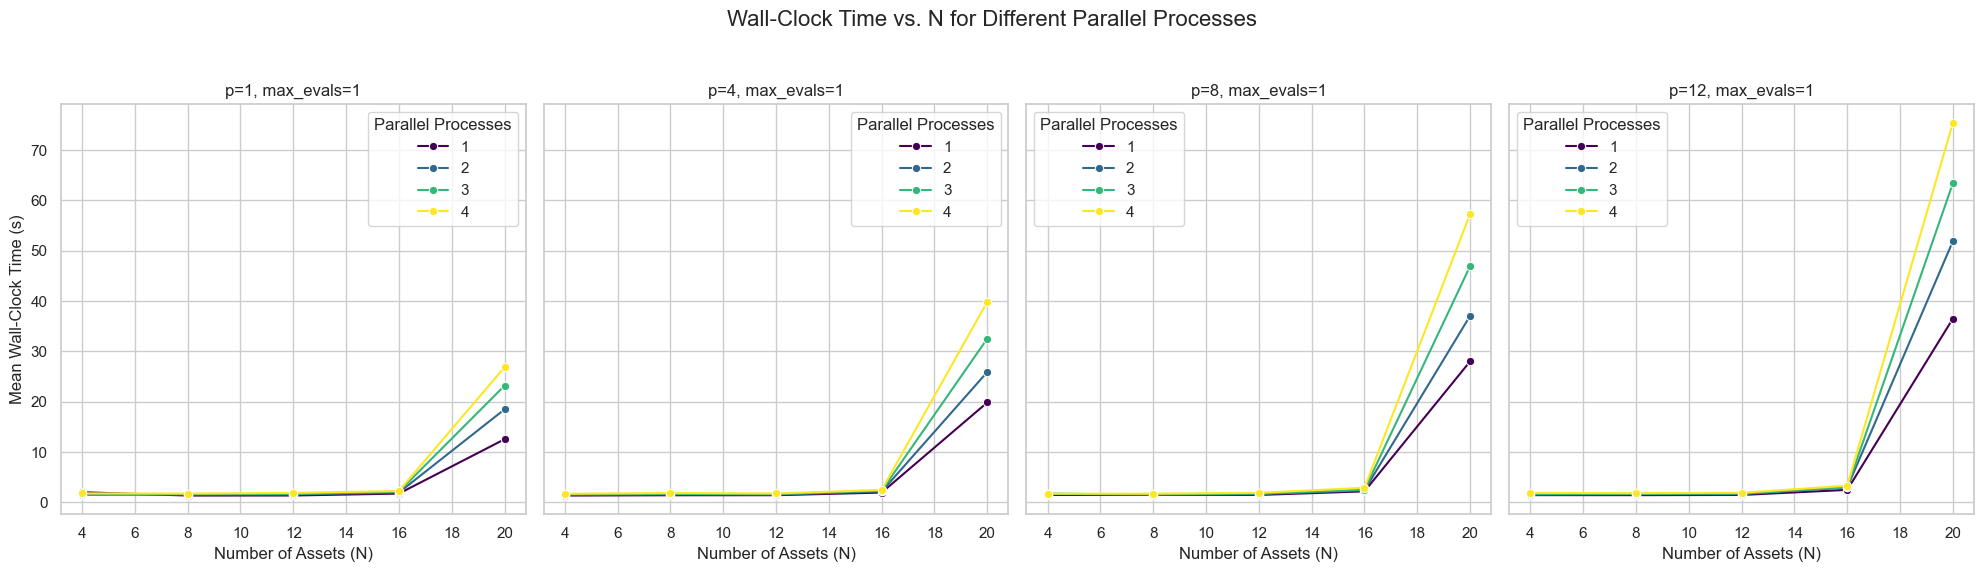


--- Plotting Speedup vs. Number of Parallel Runs ---


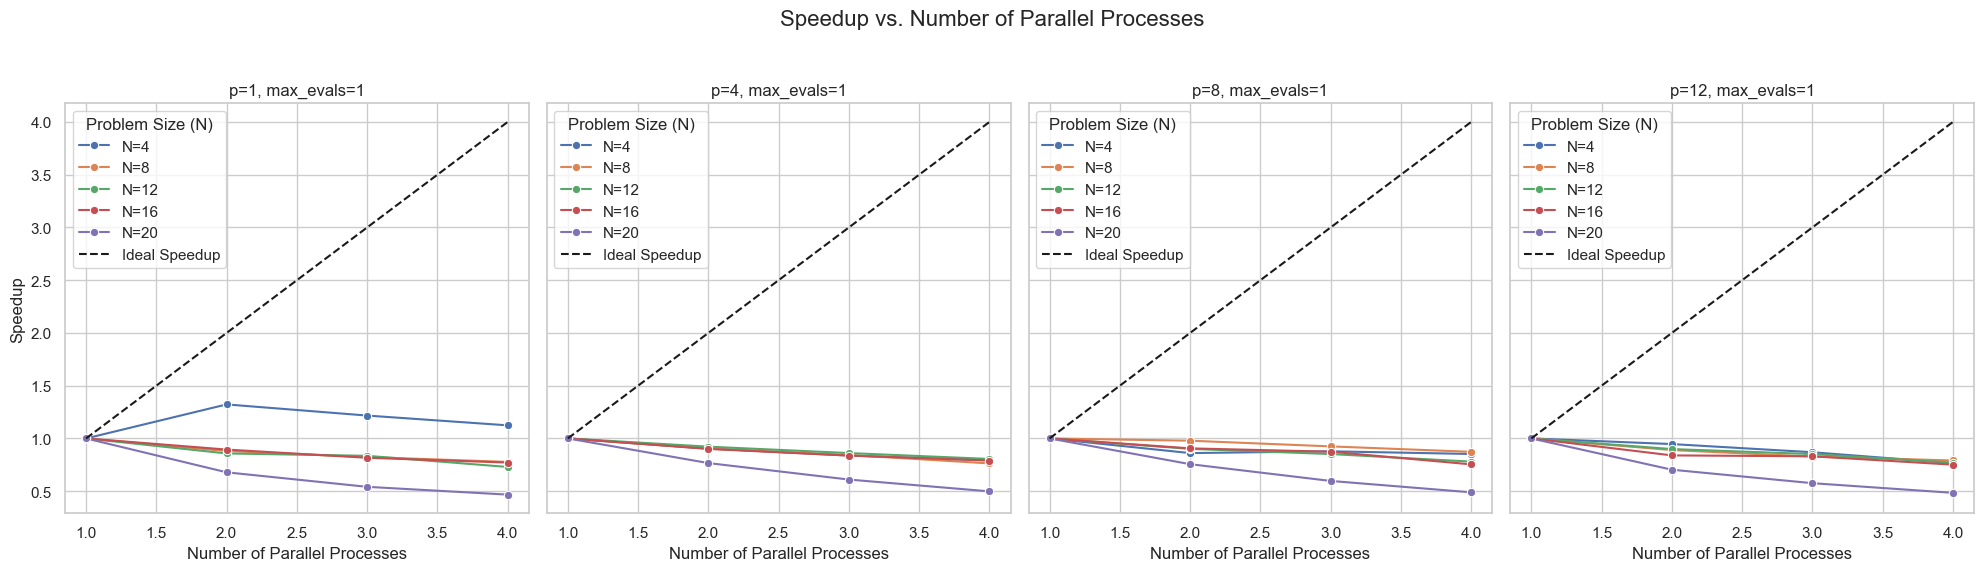


--- Plotting Mean Approximation Ratio (AR) vs. N ---


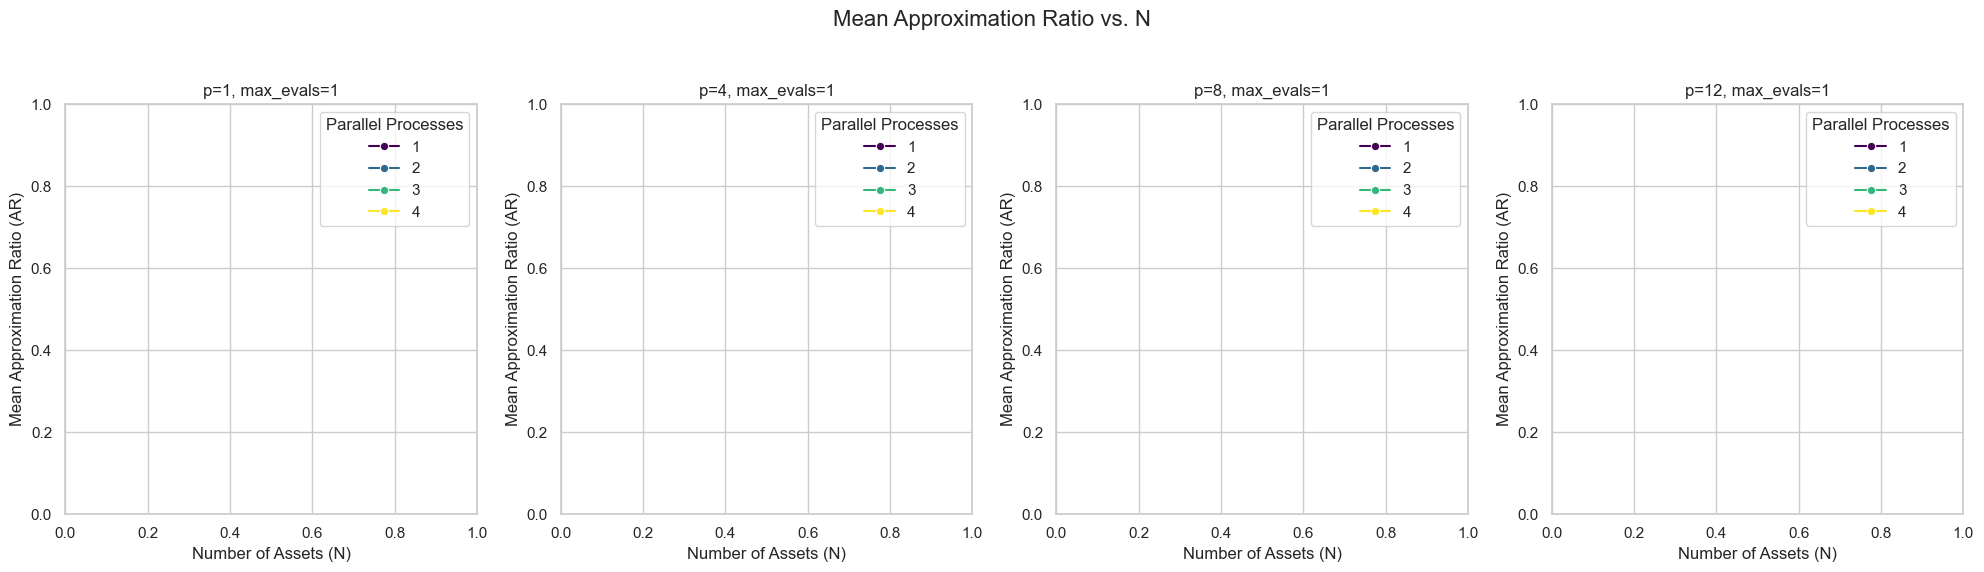


--- Plotting Mean Energy vs. max_evals ---


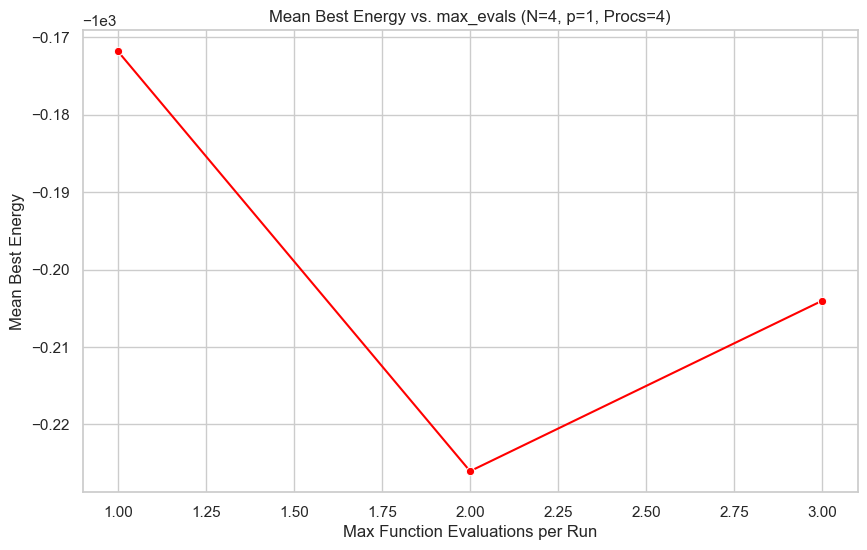


--- Plotting Constraint Satisfaction Rate vs. N ---


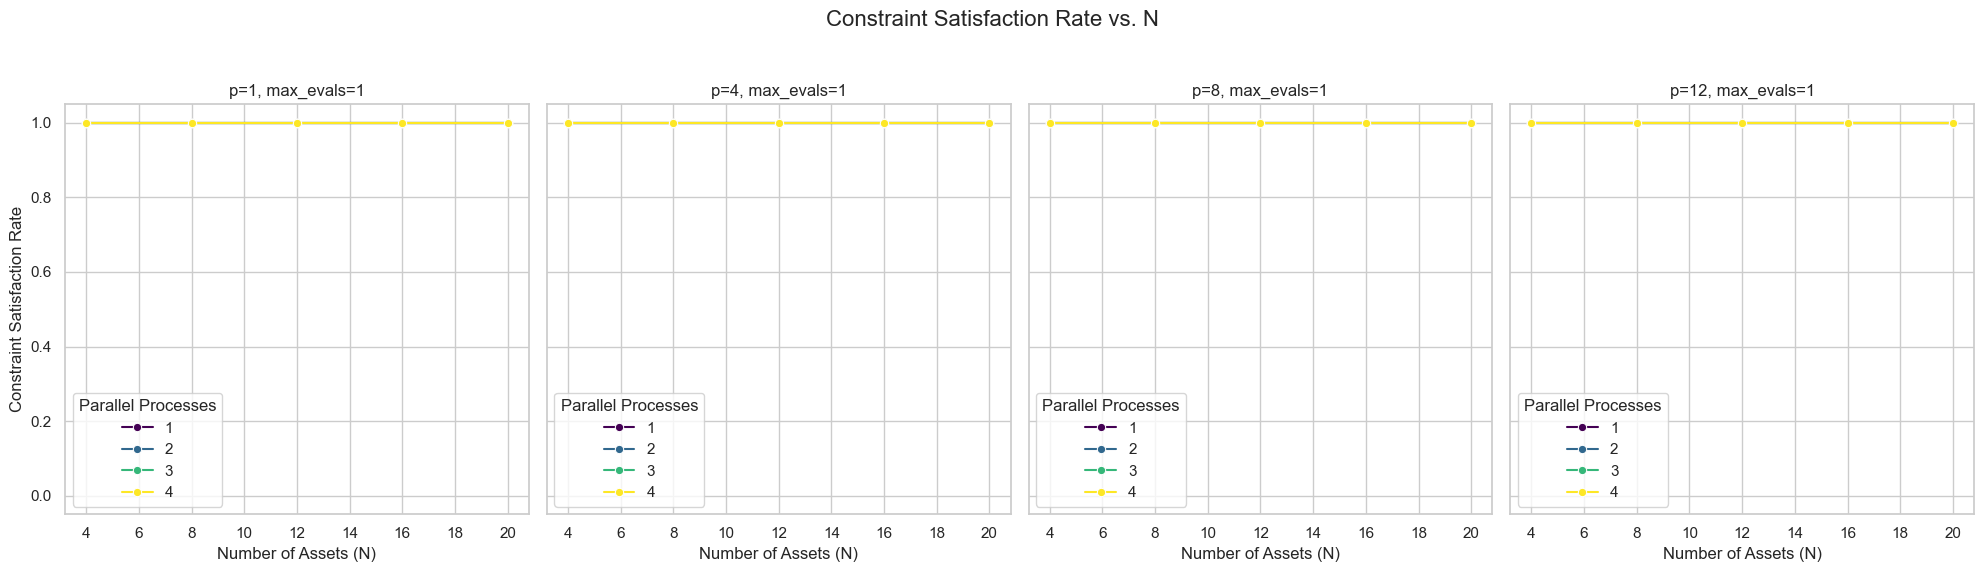

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Imported for completeness, though not strictly used in this cell for plotting

# Load the results (useful if you ran benchmarking in a separate session or restarted kernel)
try:
    df_results = pd.read_csv("qaoa_dwe_benchmarking_results.csv")
    print("Loaded results from CSV.")
except FileNotFoundError:
    print("No CSV found. Please ensure the benchmarking section (Section 4) was run successfully to generate data.")
    df_results = pd.DataFrame() # Create empty DataFrame to avoid errors if no data

if not df_results.empty:
    # --- FIX START ---
    # Ensure 'best_ar' and other numeric columns are correctly typed after loading from CSV.
    # 'errors='coerce' will turn any values that cannot be converted to numeric into NaN.
    df_results['best_ar'] = pd.to_numeric(df_results['best_ar'], errors='coerce')
    df_results['best_energy'] = pd.to_numeric(df_results['best_energy'], errors='coerce')
    df_results['total_wall_time_s'] = pd.to_numeric(df_results['total_wall_time_s'], errors='coerce')
    # --- FIX END ---

    # Calculate mean and standard deviation for key metrics across repetitions
    summary_df = df_results.groupby(['N', 'K', 'p', 'max_evals_per_run', 'num_parallel_runs']).agg(
        mean_wall_time=('total_wall_time_s', 'mean'),
        std_wall_time=('total_wall_time_s', 'std'),
        mean_energy=('best_energy', 'mean'),
        std_energy=('best_energy', 'std'),
        mean_ar=('best_ar', 'mean'),
        std_ar=('best_ar', 'std'),
        constraint_satisfaction_rate=('constraint_satisfied', lambda x: (x == True).sum() / len(x))
    ).reset_index()

    print("\n--- Summary of Aggregated Benchmarking Results ---")
    display(summary_df.head())

    # --- Plotting Configuration ---
    sns.set_theme(style="whitegrid")
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['font.size'] = 12

    # Assuming N_values and p_values are defined elsewhere or need to be inferred
    # For plotting, we need these. If not available, you might need to manually set them
    # or extract them from the dataframe.
    N_values = sorted(df_results['N'].unique())
    p_values = sorted(df_results['p'].unique())
    max_evals_values = sorted(df_results['max_evals_per_run'].unique())
    num_parallel_runs_values = sorted(df_results['num_parallel_runs'].unique())


    # --- 1. Wall-Clock Time vs. N (Scaling Performance) ---
    print("\n--- Plotting Wall-Clock Time vs. N ---")
    fig, axes = plt.subplots(1, len(p_values), figsize=(5 * len(p_values), 6), sharey=True)
    if len(p_values) == 1: axes = [axes]

    for i, p_val in enumerate(p_values):
        ax = axes[i]
        plot_df = summary_df[(summary_df['p'] == p_val) & (summary_df['max_evals_per_run'] == max_evals_values[0])]
        sns.lineplot(data=plot_df, x='N', y='mean_wall_time', hue='num_parallel_runs', marker='o', ax=ax, palette='viridis')
        ax.set_title(f'p={p_val}, max_evals={max_evals_values[0]}')
        ax.set_xlabel('Number of Assets (N)')
        ax.set_ylabel('Mean Wall-Clock Time (s)')
        ax.legend(title='Parallel Processes')
    plt.suptitle('Wall-Clock Time vs. N for Different Parallel Processes', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- 2. Speedup vs. Number of Parallel Runs (Parallelization Efficiency) ---
    print("\n--- Plotting Speedup vs. Number of Parallel Runs ---")
    fig, axes = plt.subplots(1, len(p_values), figsize=(5 * len(p_values), 6), sharey=True)
    if len(p_values) == 1: axes = [axes]

    for i, p_val in enumerate(p_values):
        ax = axes[i]
        plot_df = summary_df[(summary_df['p'] == p_val) & (summary_df['max_evals_per_run'] == max_evals_values[0])]

        for N_val in N_values:
            baseline_row = plot_df[(plot_df['N'] == N_val) & (plot_df['num_parallel_runs'] == 1)]
            if not baseline_row.empty and baseline_row['mean_wall_time'].iloc[0] > 0:
                baseline_time = baseline_row['mean_wall_time'].iloc[0]
                plot_df_N = plot_df[plot_df['N'] == N_val].copy()
                plot_df_N['speedup'] = baseline_time / plot_df_N['mean_wall_time']
                sns.lineplot(data=plot_df_N, x='num_parallel_runs', y='speedup', label=f'N={N_val}', marker='o', ax=ax)
            else:
                print(f"Warning: Baseline for N={N_val}, p={p_val} not found or time is zero. Skipping speedup plot for this N.")

        ax.plot([1, max(num_parallel_runs_values)], [1, max(num_parallel_runs_values)], 'k--', label='Ideal Speedup')
        ax.set_title(f'p={p_val}, max_evals={max_evals_values[0]}')
        ax.set_xlabel('Number of Parallel Processes')
        ax.set_ylabel('Speedup')
        ax.legend(title='Problem Size (N)')
    plt.suptitle('Speedup vs. Number of Parallel Processes', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- 3. Mean Approximation Ratio (AR) vs. N (Solution Quality Scaling) ---
    print("\n--- Plotting Mean Approximation Ratio (AR) vs. N ---")
    fig, axes = plt.subplots(1, len(p_values), figsize=(5 * len(p_values), 6), sharey=False)
    if len(p_values) == 1: axes = [axes]

    for i, p_val in enumerate(p_values):
        ax = axes[i]
        plot_df = summary_df[(summary_df['p'] == p_val) & (summary_df['max_evals_per_run'] == max_evals_values[0])]
        sns.lineplot(data=plot_df, x='N', y='mean_ar', hue='num_parallel_runs', marker='o', ax=ax, palette='viridis')
        ax.set_title(f'p={p_val}, max_evals={max_evals_values[0]}')
        ax.set_xlabel('Number of Assets (N)')
        ax.set_ylabel('Mean Approximation Ratio (AR)')
        ax.legend(title='Parallel Processes')
    plt.suptitle('Mean Approximation Ratio vs. N', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- 4. Mean Energy vs. max_evals (Optimization Effort vs. Quality) ---
    print("\n--- Plotting Mean Energy vs. max_evals ---")
    fixed_N_for_plot = N_values[0] if N_values else None
    fixed_p_for_plot = p_values[0] if p_values else None
    fixed_procs_for_plot = num_parallel_runs_values[-1] if num_parallel_runs_values else None

    if fixed_N_for_plot is not None and fixed_p_for_plot is not None and fixed_procs_for_plot is not None:
        plot_df = summary_df[
            (summary_df['N'] == fixed_N_for_plot) &
            (summary_df['p'] == fixed_p_for_plot) &
            (summary_df['num_parallel_runs'] == fixed_procs_for_plot)
        ]
        if not plot_df.empty:
            sns.lineplot(data=plot_df, x='max_evals_per_run', y='mean_energy', marker='o', color='red')
            plt.title(f'Mean Best Energy vs. max_evals (N={fixed_N_for_plot}, p={fixed_p_for_plot}, Procs={fixed_procs_for_plot})')
            plt.xlabel('Max Function Evaluations per Run')
            plt.ylabel('Mean Best Energy')
            plt.show()
        else:
            print("No data available for plotting Mean Energy vs. max_evals with selected fixed parameters.")
    else:
        print("Not enough data to plot Mean Energy vs. max_evals.")

    # --- 5. Constraint Satisfaction Rate vs. N (DWE Effectiveness) ---
    print("\n--- Plotting Constraint Satisfaction Rate vs. N ---")
    fig, axes = plt.subplots(1, len(p_values), figsize=(5 * len(p_values), 6), sharey=True)
    if len(p_values) == 1: axes = [axes]

    for i, p_val in enumerate(p_values):
        ax = axes[i]
        plot_df = summary_df[(summary_df['p'] == p_val) & (summary_df['max_evals_per_run'] == max_evals_values[0])]
        sns.lineplot(data=plot_df, x='N', y='constraint_satisfaction_rate', hue='num_parallel_runs', marker='o', ax=ax, palette='viridis')
        ax.set_title(f'p={p_val}, max_evals={max_evals_values[0]}')
        ax.set_xlabel('Number of Assets (N)')
        ax.set_ylabel('Constraint Satisfaction Rate')
        ax.set_ylim(-0.05, 1.05) # Ensure y-axis covers 0-1
        ax.legend(title='Parallel Processes')
    plt.suptitle('Constraint Satisfaction Rate vs. N', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("DataFrame is empty. Please run Section 4 to generate results before analysis.")


## 6. Optional: Analyze the Single Overall Best Result

After all benchmarking runs are complete, this section helps you retrieve and analyze the *single best* optimization result (lowest energy) found across *all* the experiments. It provides detailed information about this best-found portfolio and its classical energy.

This helps highlight the most successful outcome from your exhaustive search, providing a concrete example for your quantum technology awareness mission.

In [9]:
if not df_results.empty:
    # Sort by best energy to find the overall best result from all runs
    overall_best_row = df_results.sort_values(by='best_energy').iloc[0]

    print("\n" + "---" * 20)
    print("### Analyzing the Single Best Result from All Benchmarking Runs ###")

    # Extract details of the best run
    best_N = int(overall_best_row['N'])
    best_K = int(overall_best_row['K'])
    best_p = int(overall_best_row['p'])
    best_max_evals = int(overall_best_row['max_evals_per_run'])
    best_num_procs = int(overall_best_row['num_parallel_runs'])
    best_energy = overall_best_row['best_energy']
    best_ar = overall_best_row['best_ar']
    most_probable_bitstring = overall_best_row['most_probable_bitstring']
    selected_assets_count = int(overall_best_row['selected_assets_count'])
    constraint_satisfied = overall_best_row['constraint_satisfied']

    print(f"Overall Best Result Details:")
    print(f"  Problem Size (N): {best_N}, Assets to Select (K): {best_K}")
    print(f"  QAOA Depth (p): {best_p}, Max Evals per Run: {best_max_evals}")
    print(f"  Parallel Processes: {best_num_procs}, Repetition: {int(overall_best_row['repetition'])}")
    print(f"  Total Wall-Clock Time for this run: {overall_best_row['total_wall_time_s']:.2f} seconds")

    print(f"\nOverall Best Energy Found: {best_energy:.8f}")
    print(f"Corresponding Approximation Ratio: {best_ar}")
    print(f"Most Probable Bitstring: {most_probable_bitstring}")
    print(f"Number of Selected Assets: {selected_assets_count} (Expected K={best_K})")
    print(f"Constraint Satisfied: {'Yes' if constraint_satisfied else 'No'}")

    # To evaluate its classical energy, we need to regenerate the exact problem instance
    # using its N, K, and the corresponding problem_seed from the benchmarking loop.
    # The problem_seed was generated based on N + p_val + max_evals_per_run + num_procs + rep_idx
    reconstructed_problem_seed = int(best_N + best_p + best_max_evals + best_num_procs + overall_best_row['repetition'])
    
    reconstructed_po_problem, _ = define_po_problem(
        best_N, best_K, GLOBAL_Q, GLOBAL_LAMBDA_SUM, 
        problem_seed=reconstructed_problem_seed
    )

    # Function to evaluate classical objective energy for a given bitstring
    def evaluate_bitstring_energy(bitstring_str, original_mu, original_Sigma, original_q):
        x = np.array([int(b) for b in bitstring_str])
        portfolio_variance = np.dot(x, np.dot(original_Sigma, x))
        portfolio_return = np.dot(original_mu, x)
        return original_q * portfolio_variance - portfolio_return

    classical_energy_for_best_bitstring = evaluate_bitstring_energy(
        most_probable_bitstring,
        reconstructed_po_problem['means'], 
        reconstructed_po_problem['cov'],   
        reconstructed_po_problem['q_orig'] 
    )
    print(f"\nClassical objective energy for the most probable bitstring: {classical_energy_for_best_bitstring:.6f}")
    print("---" * 20)
else:
    print("No results available for overall best bitstring analysis. Please run Section 4 first.")


------------------------------------------------------------
### Analyzing the Single Best Result from All Benchmarking Runs ###
Overall Best Result Details:
  Problem Size (N): 10, Assets to Select (K): 4
  QAOA Depth (p): 1, Max Evals per Run: 3
  Parallel Processes: 2, Repetition: 0
  Total Wall-Clock Time for this run: 1.56 seconds

Overall Best Energy Found: -1600.08053669
Corresponding Approximation Ratio: nan
Most Probable Bitstring: 10101010
Number of Selected Assets: 4 (Expected K=4)
Constraint Satisfied: Yes
  Brute-force calculation failed for N=10: 'scale'. Approximation Ratio will be 'N/A'.


TypeError: 'numpy.int64' object is not iterable